In [1]:
import numpy as np
import pickle
import pandas as pd
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb
import random
# random.seed(10)
from hyperopt import fmin, rand, hp, Trials, tpe
rstate = np.random.default_rng(42)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl

datasets_dir = "../../data"
# plt.style.use('CCB_plot_style_0v4.mplstyle')
# c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
# high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

## Loading training, testing and validation data:

In [2]:
split = "secondary"

data_train = pd.read_pickle(join(datasets_dir, "splits", split, "training_data.pkl"))
data_test = pd.read_pickle(join(datasets_dir, "splits", split, "test_data.pkl"))
data_val = pd.read_pickle(join(datasets_dir, "splits", split, "val_data.pkl"))

# data_train["geomean_Km"] = np.log10(data_train["geomean_Km"])
# data_test["geomean_Km"] = np.log10(data_test["geomean_Km"])

data_train["log10_Km"] = np.log10(data_train["Km"])
data_test["log10_Km"] = np.log10(data_test["Km"])
data_val["log10_Km"] = np.log10(data_val["Km"])

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_val.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)
data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

len(data_train), len(data_test), len(data_val)

(250, 47, 21)

In [3]:
train_indices = list(np.load(join(datasets_dir, "splits", split, "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join(datasets_dir, "splits", split, "CV_test_indices_Seed plants.npy"), allow_pickle = True))

In [4]:
data_test = data_test[~data_test['GNN FP'].isnull()]

nan_rows = data_train[data_train['GNN FP'].apply(lambda x: not isinstance(x, np.ndarray))]

# Get the indices of these rows
indices_with_nan = nan_rows.index.tolist()
# indices_with_nan.reverse()
print(indices_with_nan)

for ind, sub_list in enumerate(train_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(train_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                train_indices[ind][i] = elem-1

for ind, sub_list in enumerate(test_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(test_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                test_indices[ind][i] = elem-1  

data_train = data_train[data_train['GNN FP'].apply(lambda x: isinstance(x, np.ndarray))]
data_train.reset_index(inplace=True, drop=True)

[]


## 1. Training a model with enzyme and main substrate information (ESM-2/MACCS) + Temperature + pH :

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train['GNN FP'])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test['GNN FP'])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 5.0, 'min_child_weight': 4.0, 'num_rounds': 750.0, 'reg_alpha': 0.4, 'reg_lambda': 0.2}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 4.0, 'num_rounds': 250.0, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 5.0, 'min_child_weight': 5.0, 'num_rounds': 1000.0, 'reg_alpha': 0.6, 'reg_lambda': 0.6}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 2.0, 'num_rounds': 750.0, 'reg_alpha': 0.0, 'reg_lambda': 0.2}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5.0, 'max_depth': 7.0, 'min_child_weight': 5.0, 'num_rounds': 750.0, 'reg_alpha': 0.6, 'reg_lambda': 0.6}

#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_gnn_fp.npy"), np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],20) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2_gnn_fp.npy"), test_Y)

In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train['GNN FP'])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test['GNN FP'])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

In [ ]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

##### Validating model:

In [ ]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [ ]:
# pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

In [ ]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

In [ ]:
# import matplotlib.pyplot as plt
# import matplotlib.colors as colors
# import matplotlib.cm as cmx

# plt.scatter(val_Y,y_val_pred, c='blue', edgecolors='black',s=15)
    
# plt.xlim(-6,2)
# plt.ylim(-6,2)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.xlabel('Real value', fontsize=15)
# plt.ylabel('Estimated value', fontsize=15)
# plt.title('Predictions', fontsize=15)
# plt.axline((1, 1), slope=1, c='red')
# plt.show()

In [ ]:
# data_combined = pd.concat([data_train, data_test],ignore_index=True)

In [ ]:
# def calculate_identity_ignore_gaps(seq1, seq2):
#     identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
#     pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
#     return pid

# from Bio import Align
# from Bio.Align import substitution_matrices

# data_val["max_identity"] = np.nan

# aligner=Align.PairwiseAligner()
# aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
# aligner.mode = "global"
# aligner.extend_gap_score = -0.5
# aligner.open_gap_score = -10

# for i in data_val.index:
#     identities = []
#     for j in data_combined.index:
#         seq1 = str(data_val["Sequence"][i])
#         seq2 = str(data_combined["Sequence"][j])
#         if 'U' in seq1:
#             seq1 = seq1.replace('U', 'C')
#         if 'U' in seq2:
#             seq2 = seq2.replace('U', 'C')
#         alignments = aligner.align(seq1, seq2)
#         identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
#     data_val["max_identity"][i] = max(identities)

In [ ]:
# data_val["max_identity"] = data_val["max_identity"]*100

In [ ]:
# import matplotlib.pyplot as plt
# import sklearn.metrics as sk
# import math

# fig, ax = plt.subplots(figsize= (10,8))
# plt.rcParams.update({'font.size': 28})

# splits = ["0-40%", "40-80%", "80-99%", "99-100%"]
# lower_bounds = [0,40,80,99]
# upper_bounds = [40,80,99,100]

# points1 = []
# points2 = []
# n_points1, n_points2 = [], []

# for i, split in enumerate(splits):

#     lb, ub = lower_bounds[i], upper_bounds[i]
    
#     help_df = data_val.loc[data_val["max_identity"]>= lb].loc[data_val["max_identity"]<= ub]
#     y_true = np.array([10**x for x in help_df["log10_Km"]])
#     y_pred = np.array([10**x for x in help_df["Estimate Km"]])
#     n_km = len(y_pred)
#     R2 =  sk.r2_score(y_true, y_pred)
#     abs_error = abs(y_true - y_pred)
#     rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
#     print(len(y_true))
#     print(split, R2, rmse)
#     points1.append(R2)
#     points2.append(rmse)
#     n_points1.append(n_km)


# ticks2 = np.array(range(len(splits)))
# labs = splits
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((-0.1,2.5))
# # plt.xlim((-0.2, 3.2))
# plt.legend(loc = "lower right", fontsize=20)
# plt.ylabel('RMSE')
# plt.xlabel('Enzyme sequence identity')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


# plt.plot([0,1,2,3], points2, c= "black", linewidth=2)

# for i, split in enumerate(splits):
#     points1.append(R2)
    
#     if i ==0:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

#     else:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
# plt.savefig(join("..","..", "data", split, "sequence_identity.png"))
# plt.show()

In [ ]:
# EC_km_pred =[[] for _ in range(6)]
# EC_km =[[] for _ in range(6)]
# for ind in data_val.index:
#     try:
#         EC = int(data_val["ECs"][ind][0][0])
#         EC_km[EC-1].append(data_val["log10_Km"][ind])
#         EC_km_pred[EC-1].append(data_val["Estimate Km"][ind])
#     except IndexError:
#         pass

In [ ]:
# fig, ax = plt.subplots(figsize= (8,8))
# plt.rcParams.update({'font.size': 28})

# classes = [str(i) for i in range(1,7)]

# for i in range(len(EC_km)):
    
#     circle = plt.Circle((np.mean(EC_km[i]), np.mean(EC_km_pred[i]) ),
#                         np.sqrt(len(EC_km_pred[i]))/300, color='navy', fill = True)
#     ax.add_artist(circle)
#     if i ==5:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_km[i])+0.01, np.mean(EC_km_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
#     else:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_km[i])+0.03, np.mean(EC_km_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

# # ticks2 = [0.2, 0.6,1,1.4,1.8]
# # labs = ticks2
# # ax.set_xticks(ticks2)
# # ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# # ax.tick_params(axis='x', length=0, rotation = 0)

# # ax.set_yticks(ticks2)
# # ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
# # ax.tick_params(axis='y', length=0, rotation = 0)

# plt.ylim((-6,-1))
# plt.xlim((-6, -1))
# plt.legend(loc = "upper left", fontsize=20)
# plt.xlabel('mean measured \n $k_{m}$ value on $\log_{10}$-scale')
# plt.ylabel('mean predicted \n $k_{m}$ value on $\log_{10}$-scale')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)
# plt.axline((1, 1), slope=1, c='grey', alpha = 0.3, linestyle='dashed')
# plt.savefig(join("..", "..", "data", split, "EC_classes_mean_km.png"))
# plt.show()

In [ ]:
# import scipy

# train_fps = [np.array(list(data_combined["MACCS FP"][ind])).reshape(1,-1) for ind in data_combined.index]
# test_fps = [np.array(list(data_val["MACCS FP"][ind])).reshape(1,-1) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["substrate_sim"] = max_sim

# data_val["substrate_sim"]= (data_val["substrate_sim"] - np.min(data_val["substrate_sim"]))
# data_val["substrate_sim"] = data_val["substrate_sim"]/np.max(data_val["substrate_sim"])

In [ ]:
# data_val["global_sim"] = (data_val["max_identity"]/100)*data_val["substrate_sim"]

In [ ]:
# data_val.describe()

In [ ]:
# import matplotlib.pyplot as plt
# import math
# import scipy as sci
# help_df = data_val

# sim_bins_lb = [0.0, 0.4, 0.8]
# sim_bins_ub = [0.4, 0.8, 1]
# r2_scores, n_points, pearson_r, rmse = [], [], [], []
# for i in range(len(sim_bins_lb)):
#     help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
#     pred = np.array([10**x for x in help_df2["log10_Km"]])
#     true = np.array([10**x for x in help_df2["Estimate Km"]])
#     r2_scores.append(sk.r2_score(true, pred))
#     pearson_r.append(sci.stats.pearsonr(true, pred)[0])
#     rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
#     n_points.append(len(pred))
#     print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

# plt.rcParams.update({'font.size': 24})

# fig, ax = plt.subplots(figsize= (8,6))

# for i in range(len(sim_bins_lb)):    
#     plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
#     ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
# plt.xlabel('Reaction similarity score')
# plt.ylabel('RMSE')
# ax.yaxis.set_label_coords(-0.2, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.23)

# ticks2 = np.array(range(len(sim_bins_lb)))
# labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((0.5,2))
# #plt.xlim((-0.5, 3.2))

# # plt.plot([-0.49, 4], [0,0], color='grey', linestyle='dashed')
# #plt.savefig(join("..","..", "data", split, "figures", "Reaction_Similarity_Score.eps"))
# plt.show()

## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH :

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 8.0, 'min_child_weight': 5.0, 'num_rounds': 500.0, 'reg_alpha': 0.4, 'reg_lambda': 0.0}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 1000.0, 'reg_alpha': 0.4, 'reg_lambda': 0.0}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 5.0, 'max_depth': 3.0, 'min_child_weight': 3.0, 'num_rounds': 500.0, 'reg_alpha': 0.6, 'reg_lambda': 0.6}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 3.0, 'min_child_weight': 3.0, 'num_rounds': 500.0, 'reg_alpha': 0.2, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 5.0, 'min_child_weight': 5.0, 'num_rounds': 250.0, 'reg_alpha': 0.8, 'reg_lambda': 0.2}


#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_diff_fp.npy"), np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2_diff_fp.npy"), test_Y)

In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

##### Validating model:

In [ ]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [ ]:
# pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

In [ ]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

## 3. Training a model with enzyme, main substrate (MACCS fp) and reaction information (ESM-2/diff_fp) + Temperature + pH :

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
# results = []

# param_grid = {'learning_rate': [0.01,0.1,0.2],
#                 'max_depth': [3,4,5,6,7,8,9,10],
#                 'reg_lambda': [0, 0.2,0.4,0.6,0.8,1],
#                 'reg_alpha': [0, 0.2,0.4,0.6,0.8,1],
#                 'max_delta_step' : [1,2,3,4,5],
#                 'min_child_weight': [1,2,3,4,5,6],
#                 'num_rounds': [100,250,500,1000]}

# params_list = [(learning_rate, max_depth, reg_lambda, reg_alpha, max_delta_step, min_child_weight, num_rounds) for learning_rate in param_grid['learning_rate'] for max_depth in param_grid["max_depth"] for reg_lambda in param_grid['reg_lambda']
#                 for reg_alpha in param_grid['reg_alpha'] for max_delta_step in param_grid['max_delta_step'] for min_child_weight in param_grid['min_child_weight'] for num_rounds in param_grid["num_rounds"]]

# params_list = random.sample(params_list, 10)

# for param in params_list:
#     params = {}
#     params["learning_rate"], params["max_depth"], params["reg_lambda"], params["reg_alpha"], params["max_delta_step"], params["min_child_weight"], params["num_rounds"] = param
#     R2 = cross_validation_mse_gradient_boosting(params)
#     results.append({"learning_rate" : params["learning_rate"], "max_depth" : params["max_depth"] , "reg_lambda" : params["reg_lambda"], "reg_alpha" : params["reg_alpha"],
#                 "max_delta_step" : params["max_delta_step"], "min_child_weight" : params["min_child_weight"], "num_rounds" : params["num_rounds"], "cv_R2" : R2})

# params = min(results, key=lambda d: d['cv_R2'])
# print(params)

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 7.0, 'min_child_weight': 1.0, 'num_rounds': 750.0, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 500.0, 'reg_alpha': 1.0, 'reg_lambda': 0.2}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 5.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.0, 'reg_lambda': 1.0}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 6.0, 'min_child_weight': 1.0, 'num_rounds': 500.0, 'reg_alpha': 0.8, 'reg_lambda': 0.6}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 2.0, 'num_rounds': 250.0, 'reg_alpha': 0.8, 'reg_lambda': 0.0}

#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2_gnn_fp_diff_fp.npy"), test_Y)

In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

##### Validating model:

In [ ]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

In [ ]:
# pd.DataFrame(list(chain(*data_val["Km_values"]))).describe()

In [ ]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

## 4. Training a model with enzyme information (ESM-2) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 2.0, 'max_depth': 8.0, 'min_child_weight': 5.0, 'num_rounds': 500.0, 'reg_alpha': 0.4, 'reg_lambda': 0.6}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000.0, 'reg_alpha': 0.4, 'reg_lambda': 0.6}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 8.0, 'min_child_weight': 3.0, 'num_rounds': 750.0, 'reg_alpha': 0.4, 'reg_lambda': 0.6}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 6.0, 'min_child_weight': 5.0, 'num_rounds': 250.0, 'reg_alpha': 0.6, 'reg_lambda': 0.6}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 750.0, 'reg_alpha': 0.2, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2.npy"), np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_ESM2.npy"), test_Y)

In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

In [ ]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter([10**x for x in val_Y],[10**x for x in y_val_pred],c='green', edgecolors='black',s=40)
    
plt.xlim(-0.0005,0.003)
plt.ylim(-0.0005,0.0015)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value', fontsize=15)
plt.ylabel('Estimated value', fontsize=15)
plt.title('Predictions for Km', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

## 5. Training a model with main substrate information (MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train['GNN FP']))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test['GNN FP']))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 5.0, 'min_child_weight': 4.0, 'num_rounds': 250.0, 'reg_alpha': 0.2, 'reg_lambda': 0.6}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 6.0, 'min_child_weight': 3.0, 'num_rounds': 750.0, 'reg_alpha': 0.8, 'reg_lambda': 0.6}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 3.0, 'min_child_weight': 5.0, 'num_rounds': 250.0, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 6.0, 'min_child_weight': 5.0, 'num_rounds': 250.0, 'reg_alpha': 0.0, 'reg_lambda': 0.2}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 1.0, 'num_rounds': 1000.0, 'reg_alpha': 0.8, 'reg_lambda': 0.0}

#### (c) Training and validating model:

In [ ]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_gnn_fp.npy"), np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_gnn_fp.npy"), test_Y)

In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["GNN FP"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["GNN FP"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

In [ ]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["GNN FP"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE,MedAE)

## 6. Training a model with reaction information (diff-fp) + Temperature + pH:

#### (a) Creating input matrices:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [ ]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))


# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [ ]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 10.0, 'min_child_weight': 4.0, 'num_rounds': 1000.0, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5.0, 'max_depth': 9.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.6, 'reg_lambda': 0.6}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 7.0, 'min_child_weight': 4.0, 'num_rounds': 750.0, 'reg_alpha': 0.2, 'reg_lambda': 0.8}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 5.0, 'max_depth': 9.0, 'min_child_weight': 5.0, 'num_rounds': 1000.0, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 7.0, 'min_child_weight': 4.0, 'num_rounds': 1000.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [ ]:

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [ ]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_diff_fp.npy"), np.array(R2))

In [ ]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_diff_fp.npy"), test_Y)

In [ ]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [ ]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [ ]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

In [ ]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

#### (e) Validating model:

In [ ]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

## 7. Training a model with reaction and main substrate information (diff-fp/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [5]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [6]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.quniform("learning_rate", 0.01, 0.2, 0.1),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.quniform("num_rounds", 100, 1000, 250)
#     }

# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 10, trials=trials, return_argmin=False)

# print(best)
# param = best
# param["random_state"] = 42

In [7]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 7.0, 'min_child_weight': 4.0, 'num_rounds': 250.0, 'reg_alpha': 0.6, 'reg_lambda': 0.2}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 4.0, 'max_depth': 3.0, 'min_child_weight': 2.0, 'num_rounds': 500.0, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
elif split == "Brassicaceae":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 5.0, 'max_depth': 7.0, 'min_child_weight': 5.0, 'num_rounds': 750.0, 'reg_alpha': 0.6, 'reg_lambda': 1.0}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 4.0, 'max_depth': 5.0, 'min_child_weight': 4.0, 'num_rounds': 1000.0, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 500.0, 'reg_alpha': 0.4, 'reg_lambda': 0.0}

#### (c) Training and validating model:

In [8]:

num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))

del param["num_rounds"]

In [9]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(R2))

[0.911512897985557, 0.7504650806218989, 0.5551865487880762, 0.8738678132255069, 0.2425516846410887]
[0.0005554832959661984, 0.0001908513064839735, 0.0002981761288115891, 0.00020523823902394514, 0.0003209029864212968]
[0.34637332954865097, 0.43624710454346793, 0.2754349928210358, 0.6721347662489111, -0.011402575732997633]
[0.00014313673853353273, 8.7617728995817e-05, 0.00014280149260773446, 0.00010022262646039075, 9.789003391770357e-05]
[4.008848722349993e-05, 1.7643661023600644e-05, 2.186878365246612e-05, 2.7783601222524153e-05, 1.663535744708803e-05]


In [10]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate Km"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],20) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split,  "y_test_true_xgboost_gnn_fp_diff_fp.npy"), test_Y)

0.0826545900047508 0.0002701144 -0.098 0.0001029741 2.13404e-05


In [11]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate Km"] = [10**x for x in data_test["Estimate Km"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [12]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_Km"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_Km"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [13]:

dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", "saved_models",
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9516636550211044, 1.0562163731480159e-24) 8.270619703109685e-05 0.8970919520366598


In [14]:
importances = bst.get_score()
print(len(data_train["ESM2"][1]))
print(len(data_train["MACCS FP"][1]))
for key, value in importances.items():
    print(f"{key}: {value}")

1280
167
f0: 2.0
f4: 1.0
f5: 2.0
f6: 6.0
f7: 5.0
f10: 3.0
f11: 1.0
f13: 11.0
f21: 5.0
f22: 12.0
f23: 5.0
f28: 21.0
f29: 16.0
f36: 8.0
f43: 7.0
f52: 7.0
f60: 5.0
f61: 17.0
f71: 3.0
f74: 7.0
f75: 12.0
f88: 6.0
f94: 8.0
f95: 5.0
f97: 3.0
f111: 3.0
f116: 7.0
f124: 44.0
f125: 4.0
f137: 1.0
f138: 17.0
f140: 1.0
f146: 3.0
f147: 1.0
f153: 1.0
f154: 1.0
f157: 2.0
f158: 3.0
f161: 2.0
f169: 1.0
f178: 1.0
f181: 13.0
f189: 1.0
f190: 5.0
f191: 23.0
f193: 5.0
f194: 1.0
f195: 1.0
f200: 7.0
f201: 16.0
f207: 3.0
f212: 2.0
f233: 6.0
f246: 21.0
f254: 7.0
f255: 1.0
f262: 3.0
f283: 1.0
f311: 2.0
f312: 12.0
f332: 1.0
f334: 5.0
f369: 1.0
f374: 4.0
f377: 2.0
f412: 1.0
f443: 4.0
f471: 3.0
f476: 1.0
f477: 4.0
f515: 1.0
f563: 1.0
f570: 2.0
f571: 6.0
f584: 2.0
f588: 1.0
f648: 1.0
f682: 4.0
f704: 1.0
f711: 1.0
f728: 13.0
f764: 1.0
f767: 1.0
f776: 13.0
f783: 3.0
f798: 4.0
f818: 3.0
f823: 8.0
f844: 10.0
f883: 6.0
f888: 2.0
f889: 1.0
f902: 1.0
f909: 6.0
f910: 3.0
f936: 6.0
f938: 3.0
f939: 1.0
f944: 1.0
f952: 2.0
f953:

#### (e) Validating model:

In [15]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_Km"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate Km"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

(0.4030734541945698, 0.07002304220449364) 0.002032604872219819 -0.06623511165822715 0.0007631478550887845 0.0001158774132279599


In [16]:
full = [5.8498930322243295e-05, 9.49666853472704e-05, 0.00010500713038469652, 7.689776561843727e-05, 8.475408008088333e-05, 7.349322704029799e-05, 9.758670974915535e-05, 8.203200504972816e-05, 8.270898137785666e-05, 8.174743186004779e-05, 6.211830268037975e-05, 8.784320435339784e-05, 8.638142432142474e-05, 8.73513464518065e-05, 7.873470682346524e-05, 6.598193159490943e-05, 0.00010052484643002498, 8.854551578167202e-05, 9.584475901661235e-05, 8.354454328797197e-05, 6.666669095553846e-05, 0.00010372869939497822, 8.04740689485728e-05, 9.966394056520772e-05, 0.00011943514372326778, 6.992565462830516e-05, 8.070582078326482e-05, 0.00010981793399883236, 0.00010204911965921736, 0.00011281861428218144, 5.822271339219495e-05, 7.044336723030585e-05, 9.16675703246548e-05, 9.236063370126437e-05, 0.00010603632738187527]
brassicaceae = [0.000161310270302122, 7.465134591487258e-05, 0.00011086368782694492, 0.00012248286848476675, 0.00015656379049307911, 0.00019614901211453296, 0.00012597315257172336, 0.00016139955907244207, 0.00012487029934719885, 0.0001490819942361992, 0.00016791817793772223, 5.6350130326119865e-05, 0.00010468606197834229, 0.0001357907185280426, 0.00014352362037649356, 0.00019631613777926798, 0.00010304207726361617, 0.00012220626868329512, 0.00011254235469373724, 0.00014083955706643272, 0.00021083112971601395, 8.194984911494348e-05, 8.426112149543068e-05, 0.00012534638448277323, 0.00021505693639679375, 0.0001786524585622092, 5.809772865275494e-05, 0.00013028537814866798, 0.0001132895225029875, 0.0002215845557214492, 0.00019152838077351767, 6.464209421744709e-05, 8.727318308536297e-05, 0.00011102660102442407, 0.00014007553452933266]
arabidopsis = [0.00017282094958153047, 0.00018300866672262792, 0.00012006103221427479, 7.32467453058181e-05, 0.00017047370814420368, 0.00016915642154010903, 0.0001707214352388835, 0.00012084615635587482, 9.18038382348131e-05, 0.00017981324048778525, 0.0001584528583316939, 0.00016465310376684848, 0.00012381558053292392, 9.088704906004571e-05, 0.0002260681440502557, 0.0001531438752887578, 0.00014935816598480445, 0.00017024625833041252, 9.893591678356729e-05, 0.00016729467486736996, 0.0001623568717206664, 0.0001883438770322247, 0.00011098265329424154, 0.00010367282009461672, 0.00021540805379090638, 0.0002270412106641409, 0.0001336796868424951, 0.00011500101780665561, 0.00010819329018002619, 0.0002509141618217177, 0.00014279310680168176, 0.00012940387663832288, 0.00013168919926854632, 7.483231849384733e-05, 0.00020227860271060456]
wildtype = [0.00011150709315642873, 7.756950917798774e-05, 0.00014766395633709635, 0.00010210448273474635, 5.9125020721710345e-05, 9.278506468821756e-05, 8.080331777335417e-05, 0.0001226460694961916, 0.00011636954467036817, 7.096824013213843e-05, 9.278506468821756e-05, 8.080331777335417e-05, 0.0001226460694961916, 0.00011636954467036817, 7.096824013213843e-05, 0.00010160165414274628, 8.275330492923819e-05, 0.00011621326784285917, 0.00011045839448633522, 5.993952080295585e-05, 0.0002058106954727906, 0.00018956797605949806, 0.0002128818517682166, 0.00018995727729568545, 0.00015661174512553616, 9.134298869167879e-05, 8.734167171552671e-05, 0.00016136860384483357, 9.538510357008452e-05, 7.343345522619391e-05, 8.111580387753833e-05, 8.387642149995726e-05, 0.0001442806747954864, 8.557916768965139e-05, 6.721062470758163e-05]
secondary = [4.402867855541495e-05, 6.585325998510999e-05, 3.2948771929013146e-05, 7.634454788779882e-05, 2.9763541238050823e-05, 4.3935911524319436e-05, 3.2126165230534316e-05, 2.7515805348083702e-05, 5.175251543612183e-05, 2.2740583653679436e-05, 2.482024871521398e-05, 7.246230959778643e-05, 2.244813253836015e-05, 5.5931376107187946e-05, 1.3045890398064937e-05, 3.1485585508387895e-05, 3.7932510961464575e-05, 3.471700013218737e-05, 3.535732095490062e-05, 2.288702891838941e-05, 3.4838415880381776e-05, 3.5570255588528626e-05, 3.4602710780501275e-05, 6.987935032027305e-05, 3.6037959400479275e-05, 3.24616845626503e-05, 3.770670536476129e-05, 2.4052792021037533e-05, 3.12880914253343e-05, 2.787376233781662e-05, 4.198833984851883e-05, 3.976653087950103e-05, 2.502658872099611e-05, 3.516790408571062e-05, 1.4317344946594623e-05]

data_frame = pd.DataFrame({"Seed plants": full, "Brassicaceae": brassicaceae, "Arabidopsis" : arabidopsis,
                             "Wildtype" : wildtype, "Secondary metabolites" : secondary}).melt()

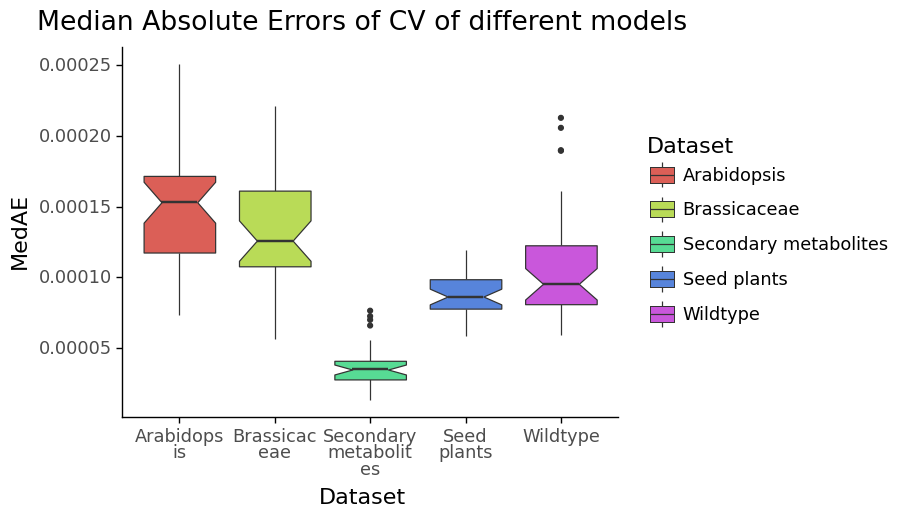

<ggplot: (-9223371919808592612)>

In [17]:
from plotnine import (
    ggplot,
    aes,
    geom_boxplot,
    labs,
    theme_classic,
    scale_x_discrete
)

import textwrap

(
    ggplot(data_frame, aes(x = "variable", y="value"))
    + geom_boxplot(aes(fill="variable"), notch=True) 
    + scale_x_discrete(labels= [textwrap.fill(label, width=9) for label in ["Arabidopsis","Brassicaceae", "Secondary metabolites", "Seed plants", "Wildtype"]])
    + labs(title="Median Absolute Errors of CV of different models", x="Dataset", y="MedAE", fill="Dataset")
    + theme_classic(base_size=16)
)
